# WEEK 3 — Dynamic Programming Projects
### Jack’s Car Rental & Gambler’s Problem

#### IMPORTS (COMMON CELL)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial, exp
import seaborn as sns


In [2]:
# ----------- Problem Constants -----------

MAX_CARS = 20
MAX_MOVE = 5

RENT_REWARD = 10
MOVE_COST = 2

GAMMA = 0.9

# Poisson means
REQ_1, REQ_2 = 3, 4
RET_1, RET_2 = 3, 2

# ----------- SPEED SETTINGS -----------
EVAL_ITERS = 5          # ### CHANGED FOR SPEED ###
THETA = 1e-2            # ### CHANGED FOR SPEED ###
MAX_POLICY_ITERS = 6    # ### CHANGED FOR SPEED ###


In [3]:
def poisson(n, lam):
    return (lam ** n) * exp(-lam) / factorial(n)


In [4]:
# Precompute Poisson probabilities (HUGE speedup)
POISSON_CACHE = {}
for lam in [REQ_1, REQ_2, RET_1, RET_2]:
    for n in range(11):   # truncation
        POISSON_CACHE[(n, lam)] = poisson(n, lam)


### JACK'S CAR RENTAL PROBLEM


In [5]:
def expected_return(state, action, V):
    """
    state = (cars_loc1, cars_loc2)
    action = cars moved from loc1 -> loc2 (can be negative)
    """
    returns = - MOVE_COST * abs(action)

    cars1 = min(state[0] - action, MAX_CARS)
    cars2 = min(state[1] + action, MAX_CARS)

    for req1 in range(11):
        for req2 in range(11):
            prob_req = (
                POISSON_CACHE[(req1, REQ_1)] *
                POISSON_CACHE[(req2, REQ_2)]
            )

            rent1 = min(cars1, req1)
            rent2 = min(cars2, req2)

            reward = (rent1 + rent2) * RENT_REWARD

            cars1_after = cars1 - rent1
            cars2_after = cars2 - rent2

            for ret1 in range(11):
                for ret2 in range(11):
                    prob_ret = (
                        POISSON_CACHE[(ret1, RET_1)] *
                        POISSON_CACHE[(ret2, RET_2)]
                    )

                    cars1_final = min(cars1_after + ret1, MAX_CARS)
                    cars2_final = min(cars2_after + ret2, MAX_CARS)

                    returns += prob_req * prob_ret * (
                        reward + GAMMA * V[cars1_final, cars2_final]
                    )

    return returns


In [6]:
V = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
policy = np.zeros_like(V, dtype=int)


In [7]:
for policy_iter in range(MAX_POLICY_ITERS):
    print(f"Policy Iteration {policy_iter + 1}")

    # -------- POLICY EVALUATION (Approximate) --------
    for _ in range(EVAL_ITERS):  # ### CHANGED FOR SPEED ###
        new_V = V.copy()
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                action = policy[i, j]
                new_V[i, j] = expected_return((i, j), action, V)
        V = new_V

    # -------- POLICY IMPROVEMENT --------
    policy_stable = True

    for i in range(MAX_CARS + 1):
        for j in range(MAX_CARS + 1):
            old_action = policy[i, j]

            action_values = []
            for action in range(-MAX_MOVE, MAX_MOVE + 1):
                if 0 <= i - action <= MAX_CARS and 0 <= j + action <= MAX_CARS:
                    action_values.append(
                        expected_return((i, j), action, V)
                    )
                else:
                    action_values.append(-np.inf)

            best_action = np.argmax(action_values) - MAX_MOVE
            policy[i, j] = best_action

            if old_action != best_action:
                policy_stable = False

    if policy_stable:
        print("Policy converged.")
        break


Policy Iteration 1
Policy Iteration 2
Policy Iteration 3
Policy Iteration 4
Policy Iteration 5
Policy Iteration 6
Policy converged.


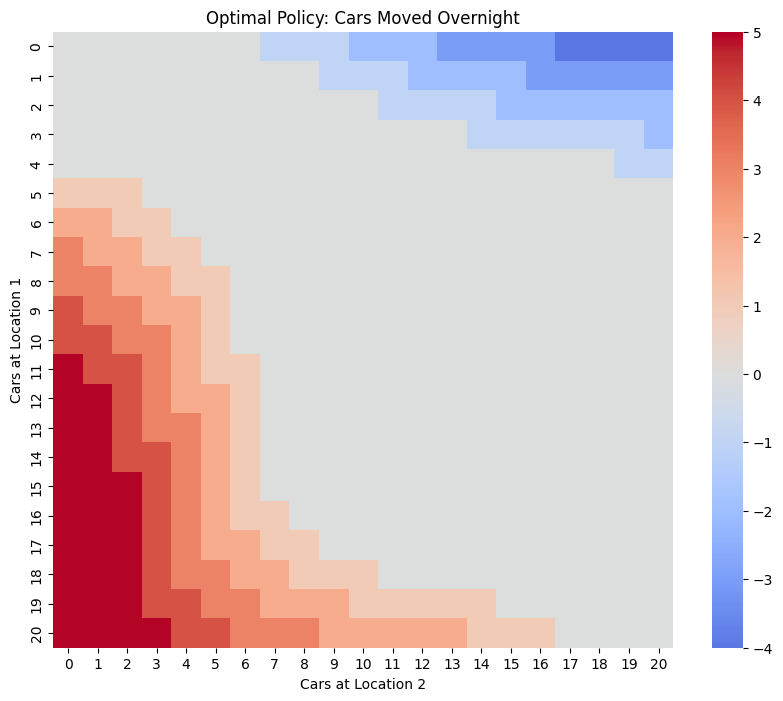

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(policy, cmap="coolwarm", center=0)
plt.xlabel("Cars at Location 2")
plt.ylabel("Cars at Location 1")
plt.title("Optimal Policy: Cars Moved Overnight")
plt.show()


#### GAMBLER'S PROBLEM 

In [9]:
import numpy as np
import matplotlib.pyplot as plt


In [10]:
GOAL = 100
p_h = 0.4

THETA = 1e-4     # ### CHANGED FOR SPEED ###
MAX_ITERS = 200  # ### CHANGED FOR SPEED ###


In [11]:
V = np.zeros(GOAL + 1)
V[GOAL] = 1.0

policy = np.zeros(GOAL + 1)


In [12]:
for iteration in range(MAX_ITERS):
    delta = 0
    for s in range(1, GOAL):
        actions = range(1, min(s, GOAL - s) + 1)
        action_returns = []

        for a in actions:
            win = p_h * V[s + a]
            lose = (1 - p_h) * V[s - a]
            action_returns.append(win + lose)

        best_value = max(action_returns)
        delta = max(delta, abs(best_value - V[s]))
        V[s] = best_value

    if delta < THETA:
        print(f"Converged at iteration {iteration}")
        break


Converged at iteration 8


In [13]:
for s in range(1, GOAL):
    actions = range(1, min(s, GOAL - s) + 1)
    action_returns = []

    for a in actions:
        win = p_h * V[s + a]
        lose = (1 - p_h) * V[s - a]
        action_returns.append(win + lose)

    policy[s] = actions[np.argmax(action_returns)]


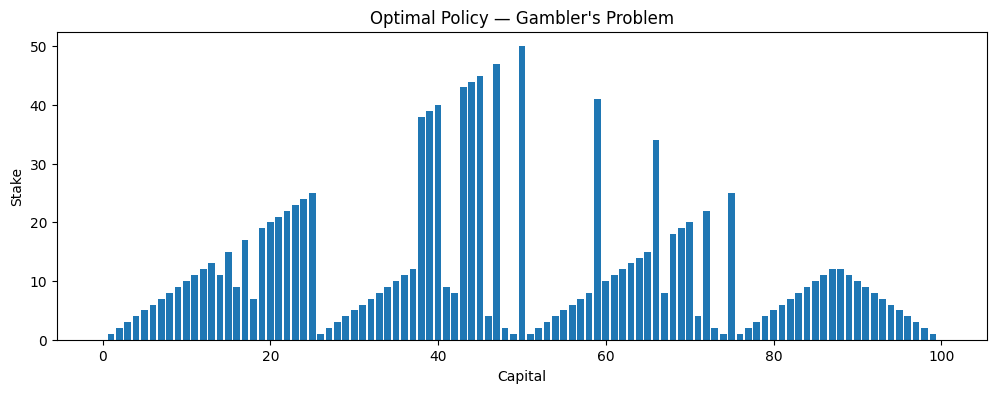

In [14]:
plt.figure(figsize=(12, 4))
plt.bar(range(GOAL + 1), policy)
plt.xlabel("Capital")
plt.ylabel("Stake")
plt.title("Optimal Policy — Gambler's Problem")
plt.show()
